<a href="https://colab.research.google.com/github/sandeeps2004/JPM-QuantResearch-Virtual-Task-4/blob/main/bucket__FICO_scores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('Task 3 and 4_Loan_Data.csv')

In [5]:
print(df.head())
print(df.describe()[["fico_score"]])

   customer_id  credit_lines_outstanding  loan_amt_outstanding  \
0      8153374                         0           5221.545193   
1      7442532                         5           1958.928726   
2      2256073                         0           3363.009259   
3      4885975                         0           4766.648001   
4      4700614                         1           1345.827718   

   total_debt_outstanding       income  years_employed  fico_score  default  
0             3915.471226  78039.38546               5         605        0  
1             8228.752520  26648.43525               2         572        1  
2             2027.830850  65866.71246               4         602        0  
3             2501.730397  74356.88347               5         612        0  
4             1768.826187  23448.32631               6         631        0  
         fico_score
count  10000.000000
mean     637.557700
std       60.657906
min      408.000000
25%      597.000000
50%      638.00

In [6]:
def calculate_pd_buckets(data, col_fico="fico_score", col_default="default"):
    """Compute PD and related stats per FICO bucket."""
    bucket_summary = (
        data.groupby("fico_bucket")
        .agg(
            total_borrowers=(col_default, "count"),
            defaults=(col_default, "sum"),
            avg_fico=(col_fico, "mean"),
        )
        .reset_index()
    )
    bucket_summary["PD (%)"] = (bucket_summary["defaults"] / bucket_summary["total_borrowers"]) * 100
    return bucket_summary

In [7]:
NUM_BUCKETS = 10
df["bucket_equal"] = pd.cut(df["fico_score"], bins=NUM_BUCKETS)

equal_df = df.copy()
equal_df["fico_bucket"] = equal_df["bucket_equal"]
equal_summary = calculate_pd_buckets(equal_df)

/tmp/ipython-input-3400136546.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby("fico_bucket")


In [8]:
df["bucket_quantile"] = pd.qcut(df["fico_score"], q=NUM_BUCKETS, duplicates="drop")

quant_df = df.copy()
quant_df["fico_bucket"] = quant_df["bucket_quantile"]
quant_summary = calculate_pd_buckets(quant_df)


/tmp/ipython-input-3400136546.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby("fico_bucket")


In [ ]:
# Calculate the Probability of Default (PD) for each rating.
pd_by_rating = df.groupby('rating')['default'].mean().reset_index()
pd_by_rating.rename(columns={'default': 'Probability of Default (PD)'}, inplace=True)

print("\n--- Probability of Default (PD) by Optimal Rating ---")
print(pd_by_rating.sort_values('rating'))


--- Probability of Default (PD) by Optimal Rating ---
   rating  Probability of Default (PD)
0       1                     0.046470
1       2                     0.105099
2       3                     0.204479
3       4                     0.380952
4       5                     0.661130


In [11]:
def log_likelihood(n, k):
    """Compute log-likelihood for k defaults out of n observations."""
    if n == 0 or k == 0 or k == n:
        return 0
    p = k / n
    return k * np.log(p) + (n - k) * np.log(1 - p)

def optimize_buckets(fico, defaults, r=10):
    """
    Dynamic programming approach for maximum log-likelihood bucketing.
    Args:
        fico (list[int]): FICO scores (sorted)
        defaults (list[int]): Default flags
        r (int): Number of buckets
    Returns:
        List[int]: Optimal bucket boundaries
    """
    min_score, max_score = min(fico), max(fico)
    range_size = max_score - min_score + 1

    total = np.zeros(range_size)
    default = np.zeros(range_size)

    # Step 1: Aggregate defaults and totals per score
    for f, d in zip(fico, defaults):
        idx = f - min_score
        total[idx] += 1
        default[idx] += d

    # Step 2: Prefix sums
    for i in range(1, range_size):
        total[i] += total[i - 1]
        default[i] += default[i - 1]

    # Step 3: DP initialization
    dp = np.full((r + 1, range_size), -1e18)
    prev = np.zeros((r + 1, range_size), dtype=int)

    for i in range(range_size):
        dp[1][i] = log_likelihood(total[i], default[i])

    # Step 4: DP computation
    for bucket in range(2, r + 1):
        for end in range(bucket - 1, range_size):
            for k in range(bucket - 2, end):
                if total[end] == total[k]:
                    continue
                n_segment = total[end] - total[k]
                d_segment = default[end] - default[k]
                score = dp[bucket - 1][k] + log_likelihood(n_segment, d_segment)
                if score > dp[bucket][end]:
                    dp[bucket][end] = score
                    prev[bucket][end] = k

    # Step 5: Backtrack to find boundaries
    boundaries = []
    end = range_size - 1
    for bucket in range(r, 0, -1):
        boundaries.append(end + min_score)
        end = prev[bucket][end]
    boundaries.append(min_score)
    boundaries = sorted(set(boundaries))
    return boundaries

In [15]:
# Run optimization
fico_list = df["fico_score"].astype(int).tolist()
default_list = df["default"].astype(int).tolist()
boundaries = optimize_buckets(fico_list, default_list, r=10)

print("\n=== Optimized Bucket Boundaries ===")
print(boundaries)


=== Optimized Bucket Boundaries ===
[408, np.int64(520), np.int64(552), np.int64(580), np.int64(611), np.int64(649), np.int64(696), np.int64(732), np.int64(752), np.int64(753), 850]


In [16]:
# Assign each FICO score to optimized bucket
df["bucket_optimal"] = pd.cut(df["fico_score"], bins=boundaries, include_lowest=True)
opt_df = df.copy()
opt_df["fico_bucket"] = opt_df["bucket_optimal"]
opt_summary = calculate_pd_buckets(opt_df)

/tmp/ipython-input-3400136546.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby("fico_bucket")


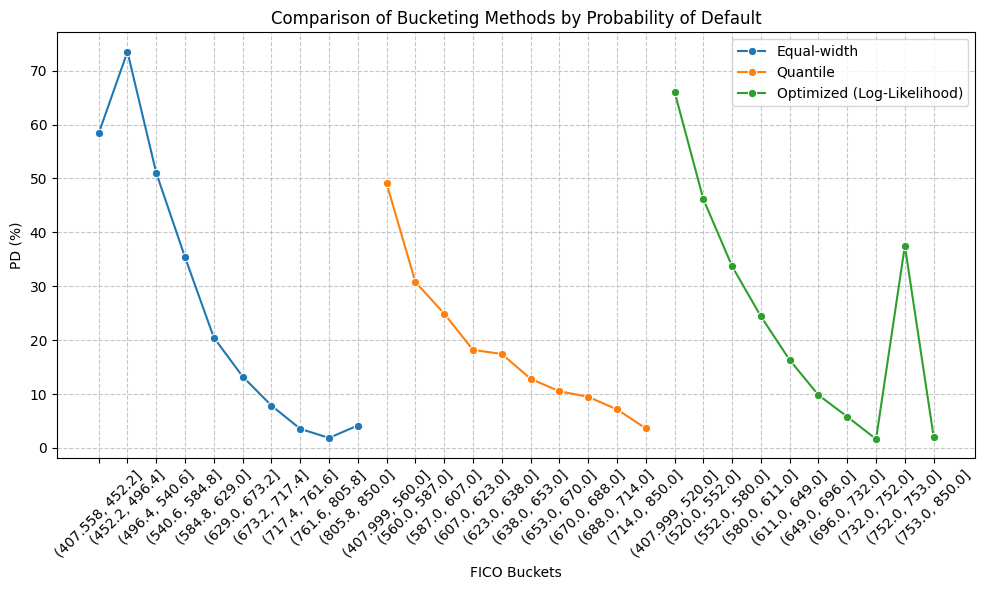

In [19]:
equal_summary["fico_bucket"] = equal_summary["fico_bucket"].astype(str)
quant_summary["fico_bucket"] = quant_summary["fico_bucket"].astype(str)
opt_summary["fico_bucket"] = opt_summary["fico_bucket"].astype(str)

plt.figure(figsize=(10, 6))
sns.lineplot(data=equal_summary, x="fico_bucket", y="PD (%)", label="Equal-width", marker="o")
sns.lineplot(data=quant_summary, x="fico_bucket", y="PD (%)", label="Quantile", marker="o")
sns.lineplot(data=opt_summary, x="fico_bucket", y="PD (%)", label="Optimized (Log-Likelihood)", marker="o")
plt.xticks(rotation=45)
plt.title("Comparison of Bucketing Methods by Probability of Default")
plt.xlabel("FICO Buckets")
plt.ylabel("PD (%)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [20]:
print("\n=== Comparative Summary ===")
for name, summary in [("Equal-width", equal_summary), ("Quantile", quant_summary), ("Optimized", opt_summary)]:
    avg_pd = summary["PD (%)"].mean()
    print(f"{name} Bucketing → Avg PD = {avg_pd:.2f}% | Buckets = {len(summary)}")


=== Comparative Summary ===
Equal-width Bucketing → Avg PD = 26.94% | Buckets = 10
Quantile Bucketing → Avg PD = 18.41% | Buckets = 10
Optimized Bucketing → Avg PD = 24.35% | Buckets = 10
